This is the program which will compare three different types of insects: 
    - vespula germanica 
    - bombus 
    - vespa crabro
Given HW will utilize fast.ai package and resnet34 + resnet50
Goal of this assignment is to load in images downloaded from Google images, clasify them, and tune the model for best error rate.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *

In [3]:
folder = 'vespula'
file = 'urls_vespula_germanica.csv'

In [4]:
path = Path('data/insects')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [5]:
download_images(path/file, dest, max_pics=200)

In [6]:
folder = 'bombus'
file = 'urls_bombus.csv'

In [7]:
path = Path('data/insects')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [8]:
download_images(path/file, dest, max_pics=200)

In [9]:
folder = 'vespa'
file = 'urls_vespa_crabro.csv'

In [10]:
path = Path('data/insects')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [11]:
download_images(path/file, dest, max_pics=200)

In [12]:
path.ls()

[PosixPath('data/insects/vespula'),
 PosixPath('data/insects/cleaned.csv'),
 PosixPath('data/insects/.ipynb_checkpoints'),
 PosixPath('data/insects/vespa'),
 PosixPath('data/insects/urls_bombus.csv'),
 PosixPath('data/insects/urls_vespula_germanica.csv'),
 PosixPath('data/insects/urls_vespa_crabro.csv'),
 PosixPath('data/insects/bombus'),
 PosixPath('data/insects/models')]

In [13]:
classes = ['vespula','vespa','bombus']


In [14]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=100)

vespula


vespa


bombus


In [15]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [16]:
data.classes


['bombus', 'vespa', 'vespula']

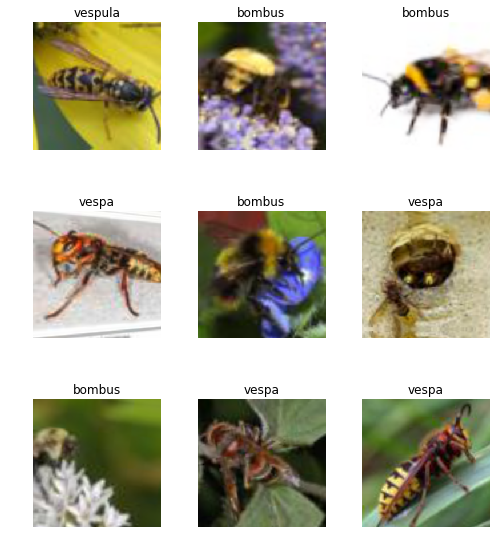

In [17]:
data.show_batch(rows=3, figsize=(7,8))

In [18]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bombus', 'vespa', 'vespula'], 3, 448, 112)

In [19]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.761352,0.944548,0.312500,00:06
1,1.193097,0.787975,0.214286,00:04
2,1.004030,0.808546,0.214286,00:04
3,0.840665,0.868761,0.223214,00:04


In [21]:
learn.save('stage-1')

In [22]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


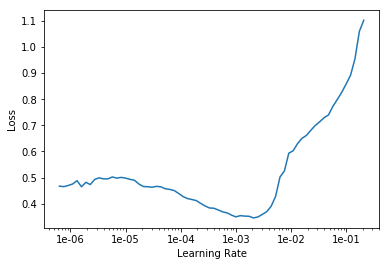

In [27]:
learn.recorder.plot()


In [28]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,7e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.018960,2.801409,0.312500,00:05
1,1.292478,3.946420,0.267857,00:05
2,1.090760,2.004246,0.169643,00:05
3,0.935138,1.247956,0.169643,00:05


In [36]:
learn.save('stage-2')

Confusion matrix for stage-1 and stage-2 to see which units were mislabeled the most

In [37]:
learn.load('stage-2');

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

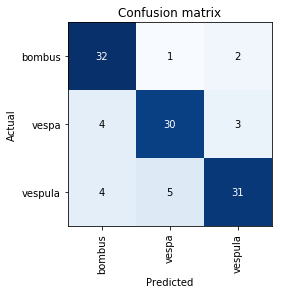

In [32]:
interp.plot_confusion_matrix()

In [33]:
learn.load('stage-1');

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

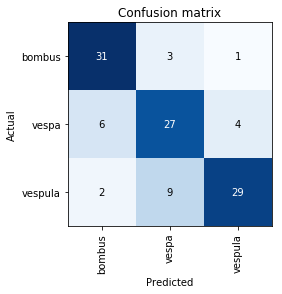

In [35]:
interp.plot_confusion_matrix()

Exporting model and validating using randomly chosen image.

In [38]:
learn.export()

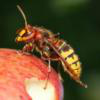

In [39]:
img = open_image(path/'vespa'/'00000021.jpg')
img

In [40]:
learn = load_learner(path)

In [41]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'vespa'

Next section is for cleaning the data.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path)